# 第3部　基本的な時系列予測の手法

## 第2章　季節調整とトレンド除去

### 分析の準備

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa

# 季節調整とトレンド除去を行う関数
from sktime.transformations.series.detrend import (
    Deseasonalizer, Detrender
)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.difference import Differencer
from statsmodels.tsa.deterministic import TimeTrend

# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 60)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

In [3]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスの作成
air_passengers.index = pd.date_range(
    start='1949-01-01', periods=len(air_passengers), freq='MS')

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

### 移動平均法による加法型の季節調整

#### トレンドと循環成分

In [4]:
# 12時点移動平均
ma_12 = air_passengers['value'].rolling(window=12, center=True).mean()

# 単純な12時点移動平均に対して、さらに移動平均をとる
# これが中心化移動平均となる
trend = ma_12.rolling(window=2).mean().shift(-1)
trend['1949']

1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01    126.791667
1949-08-01    127.250000
1949-09-01    127.958333
1949-10-01    128.583333
1949-11-01    129.000000
1949-12-01    129.750000
Freq: MS, Name: value, dtype: float64

<Axes: >

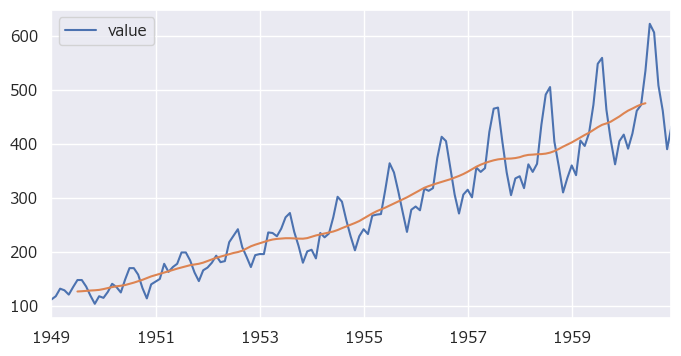

In [5]:
# 参考：原系列とトレンド成分
air_passengers.plot()
trend.plot()

#### トレンド除去

<Axes: >

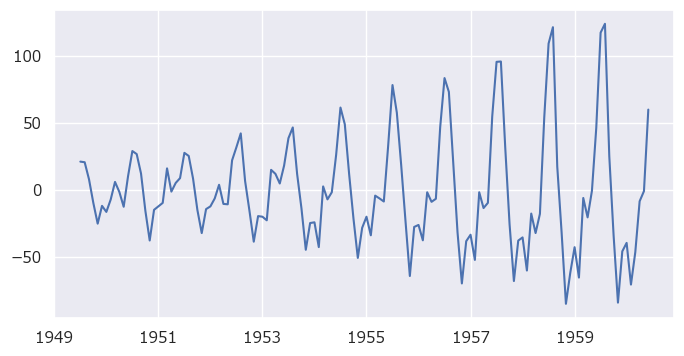

In [6]:
# トレンドを排除した結果
detrend = air_passengers['value'] - trend
detrend.plot()

#### 季節成分

In [7]:
# トレンド除去後の結果を月ごとに平均する
seasonal_year = detrend.groupby(detrend.index.month).mean()

# 季節成分の平均値が0になるようにする
seasonal_year = seasonal_year - np.mean(seasonal_year)

seasonal_year

1    -24.748737
2    -36.188131
3     -2.241162
4     -8.036616
5     -4.506313
6     35.402778
7     63.830808
8     62.823232
9     16.520202
10   -20.642677
11   -53.593434
12   -28.619949
Name: value, dtype: float64

<Axes: >

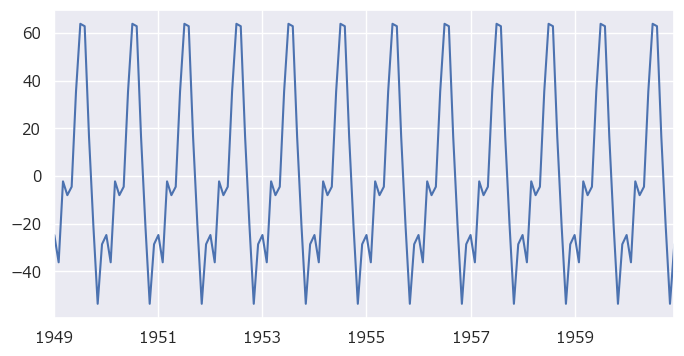

In [8]:
# 季節成分を引き延ばす
seasonal = pd.concat([seasonal_year] * (len(trend)//12))
seasonal.index = air_passengers.index
seasonal.plot()

#### 季節調整済み系列

<Axes: >

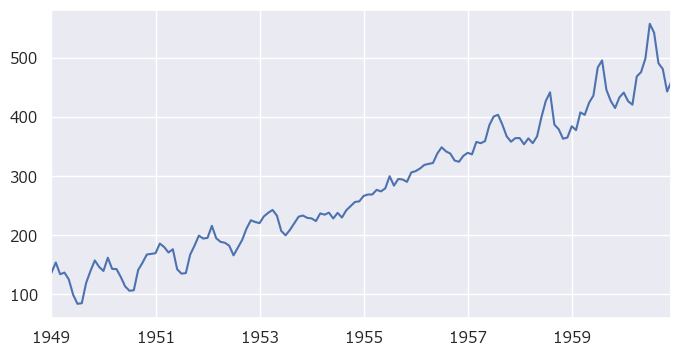

In [9]:
deseasonalized = air_passengers['value'] - seasonal
deseasonalized.plot()

#### 不規則変動成分

<Axes: >

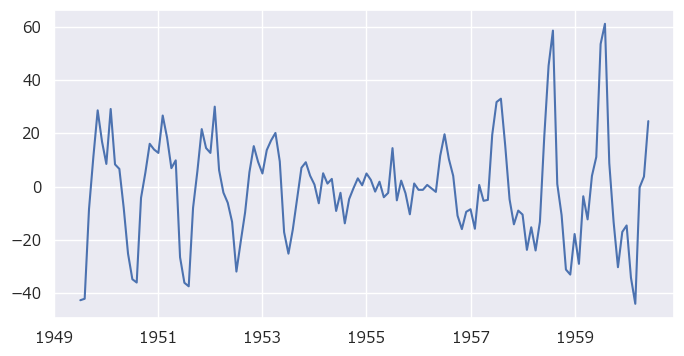

In [10]:
resid = air_passengers['value'] - trend - seasonal
resid.plot()

### 加法型の季節調整の効率的な実装

#### statsmodelsの利用 

In [11]:
# 加法型の季節分解
seasonal_decomp = tsa.seasonal_decompose(
    air_passengers, model='additive')

In [12]:
# 参考：トレンド成分
seasonal_decomp.trend.loc['1949']

1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01    126.791667
1949-08-01    127.250000
1949-09-01    127.958333
1949-10-01    128.583333
1949-11-01    129.000000
1949-12-01    129.750000
Freq: MS, Name: trend, dtype: float64

In [13]:
# 参考：季節成分
seasonal_decomp.seasonal.loc['1949']

1949-01-01   -24.748737
1949-02-01   -36.188131
1949-03-01    -2.241162
1949-04-01    -8.036616
1949-05-01    -4.506313
1949-06-01    35.402778
1949-07-01    63.830808
1949-08-01    62.823232
1949-09-01    16.520202
1949-10-01   -20.642677
1949-11-01   -53.593434
1949-12-01   -28.619949
Freq: MS, Name: seasonal, dtype: float64

In [14]:
# 参考：不規則変動
seasonal_decomp.resid.loc['1949']

1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
1949-06-01          NaN
1949-07-01   -42.622475
1949-08-01   -42.073232
1949-09-01    -8.478535
1949-10-01    11.059343
1949-11-01    28.593434
1949-12-01    16.869949
Freq: MS, Name: resid, dtype: float64

In [15]:
# 参考：推定結果の比較
np.sum((seasonal_decomp.trend - trend) ** 2)

1.983133206853206e-25

In [16]:
# 参考：推定結果の比較
np.sum((seasonal_decomp.seasonal - seasonal) ** 2)

1.4019636007587822e-26

In [17]:
# 参考：推定結果の比較
np.sum((seasonal_decomp.resid - resid) ** 2)

1.991652904629593e-25

In [18]:
# 季節調整済み系列
air_passengers['value'] - seasonal_decomp.seasonal

1949-01-01    136.748737
1949-02-01    154.188131
1949-03-01    134.241162
1949-04-01    137.036616
1949-05-01    125.506313
                 ...    
1960-08-01    543.176768
1960-09-01    491.479798
1960-10-01    481.642677
1960-11-01    443.593434
1960-12-01    460.619949
Freq: MS, Length: 144, dtype: float64

In [19]:
# 参考：推定結果の比較
sum(((air_passengers['value'] - seasonal_decomp.seasonal) - deseasonalized) ** 2)

6.15942594796566e-26

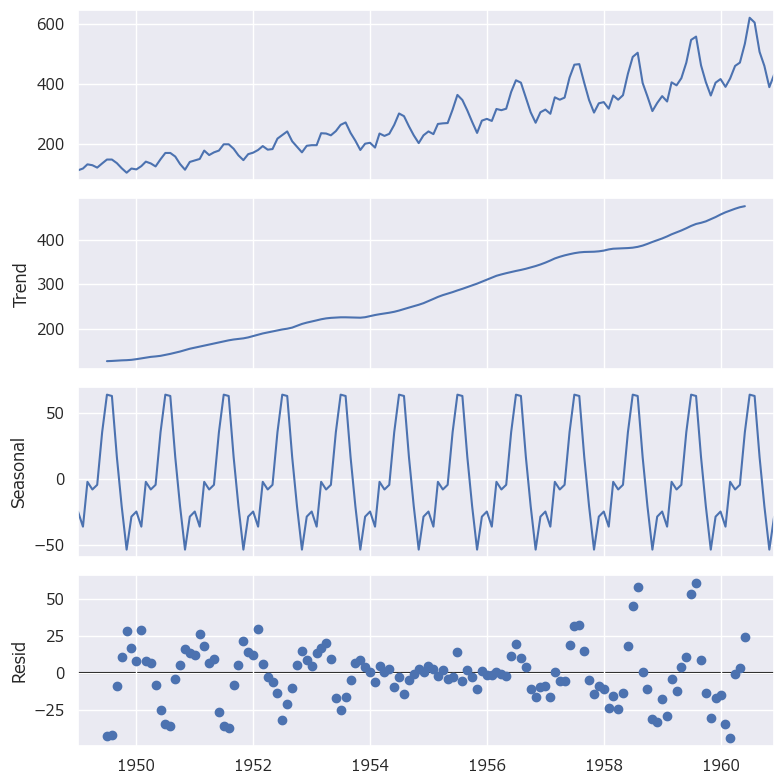

In [20]:
# 参考：推定結果の可視化
rcParams['figure.figsize'] = 8, 8
_ = seasonal_decomp.plot()
rcParams['figure.figsize'] = 8, 4

#### sktimeの利用

In [21]:
# 加法型の季節調整
transformer = Deseasonalizer(sp=12, model='additive')  

# 変換の実施
desea_sk = transformer.fit_transform(air_passengers.to_period())  

In [22]:
# 推定結果の比較
sum((desea_sk['value'] - deseasonalized.to_period()) ** 2)

6.15942594796566e-26

### 移動平均法による乗法型の季節調整

#### トレンド除去

In [23]:
# トレンドを除去した結果
detrend_mul = air_passengers['value'] / trend

#### 季節成分

In [24]:
# トレンド排除後の結果を月ごとに平均する
seasonal_year_mul = detrend_mul.groupby(detrend_mul.index.month).mean()

# 季節成分の平均値が1になるようにする
seasonal_year_mul = seasonal_year_mul / np.mean(seasonal_year_mul)

seasonal_year_mul

1     0.910230
2     0.883625
3     1.007366
4     0.975906
5     0.981378
6     1.112776
7     1.226556
8     1.219911
9     1.060492
10    0.921757
11    0.801178
12    0.898824
Name: value, dtype: float64

In [25]:
# 季節成分を引き延ばす
seasonal_mul = pd.concat([seasonal_year_mul] * (len(trend)//12))
seasonal_mul.index = air_passengers.index

#### 季節調整済み系列

<Axes: >

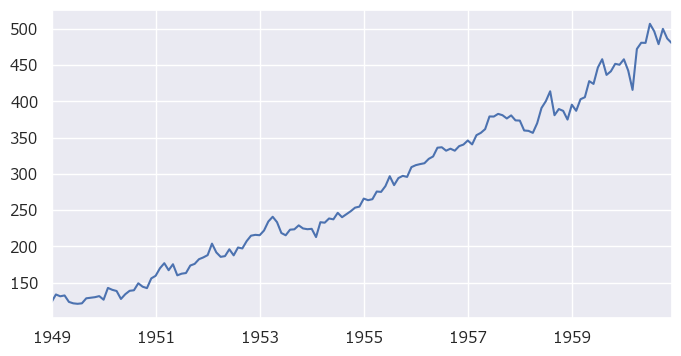

In [26]:
deseasonalized_mul = air_passengers['value'] / seasonal_mul
deseasonalized_mul.plot()

#### 不規則変動成分

<Axes: >

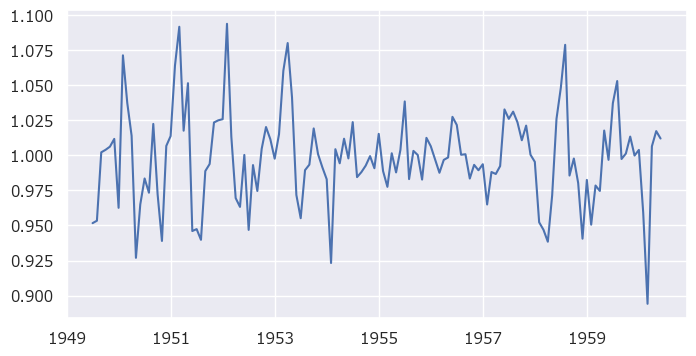

In [27]:
resid_mul = air_passengers['value'] / trend / seasonal_mul
resid_mul.plot()

### 乗法型の季節調整の効率的な実装

#### statsmodelsの利用

In [28]:
# 乗法型の季節分解
seasonal_decomp_mul = tsa.seasonal_decompose(
    air_passengers, model='multiplicative')

In [29]:
# 参考：季節成分
seasonal_decomp_mul.seasonal.loc['1949']

1949-01-01    0.910230
1949-02-01    0.883625
1949-03-01    1.007366
1949-04-01    0.975906
1949-05-01    0.981378
1949-06-01    1.112776
1949-07-01    1.226556
1949-08-01    1.219911
1949-09-01    1.060492
1949-10-01    0.921757
1949-11-01    0.801178
1949-12-01    0.898824
Freq: MS, Name: seasonal, dtype: float64

In [30]:
# 参考：不規則変動成分
seasonal_decomp_mul.resid.loc['1949']

1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01    0.951664
1949-08-01    0.953401
1949-09-01    1.002220
1949-10-01    1.004028
1949-11-01    1.006270
1949-12-01    1.011812
Freq: MS, Name: resid, dtype: float64

In [31]:
# 参考：推定結果の比較
np.sum((seasonal_decomp_mul.trend - trend) ** 2)

1.983133206853206e-25

In [32]:
# 参考：推定結果の比較
np.sum((seasonal_decomp_mul.seasonal - seasonal_mul) ** 2)

5.17689969051289e-30

In [33]:
# 参考：推定結果の比較
np.sum((seasonal_decomp_mul.resid - resid_mul) ** 2)

9.799131557042256e-30

In [34]:
# 季節調整済み系列
air_passengers['value'] / seasonal_decomp_mul.seasonal

1949-01-01    123.045774
1949-02-01    133.540764
1949-03-01    131.034760
1949-04-01    132.184860
1949-05-01    123.296015
                 ...    
1960-08-01    496.757563
1960-09-01    479.022974
1960-10-01    500.131683
1960-11-01    486.783162
1960-12-01    480.627812
Freq: MS, Length: 144, dtype: float64

In [35]:
# 参考：推定結果の比較
sum(((air_passengers['value'] / seasonal_decomp_mul.seasonal) - deseasonalized_mul) ** 2)

5.54550283708646e-25

#### sktimeの利用

In [36]:
# 乗法型の季節調整
transformer_mul = Deseasonalizer(sp=12, model='multiplicative')  

# 変換の実施
desea_sk_mul = transformer_mul.fit_transform(air_passengers.to_period())  

In [37]:
# 推定結果の比較
sum((desea_sk_mul['value'] - deseasonalized_mul.to_period()) ** 2)

5.54550283708646e-25

### 線形回帰分析によるトレンド除去

#### 説明変数を作る

In [38]:
# 説明変数を作る
trend_generator = TimeTrend(constant=True, order=1)
exog = trend_generator.in_sample(air_passengers.index)
print(exog.head(3))

            const  trend
1949-01-01    1.0    1.0
1949-02-01    1.0    2.0
1949-03-01    1.0    3.0


In [39]:
# 参考：将来予測のための説明変数を作ることもできる
print(trend_generator.out_of_sample(3, air_passengers.index))

            const  trend
1961-01-01    1.0  145.0
1961-02-01    1.0  146.0
1961-03-01    1.0  147.0


#### 加法型のトレンド除去

<Axes: >

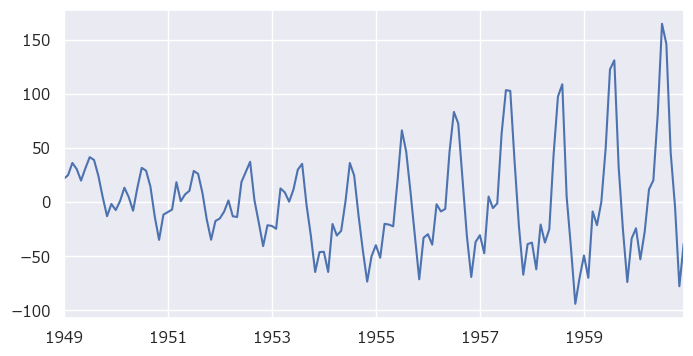

In [40]:
# 線形回帰モデルの推定
lm_model = sm.OLS(air_passengers, exog).fit()

# 加法型のトレンド除去
detrend_ols = air_passengers['value'] - lm_model.fittedvalues
detrend_ols.plot()

#### 乗法型のトレンド除去

<Axes: >

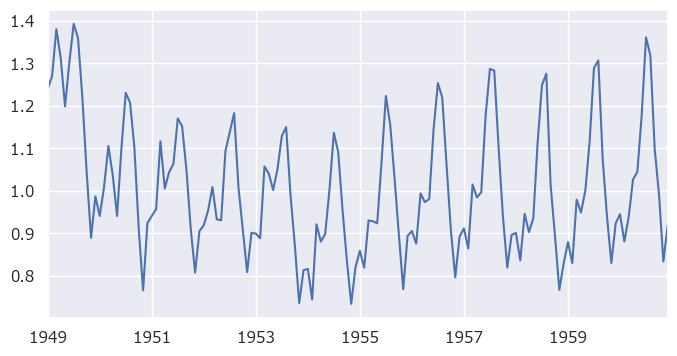

In [41]:
# 乗法型のトレンド除去
detrend_ols_mul = air_passengers['value'] / lm_model.fittedvalues
detrend_ols_mul.plot()

#### sktimeを用いた効率的な実装

In [42]:
# 加法型のトレンド除去
transformer_trend = Detrender(
    forecaster=PolynomialTrendForecaster(degree=1), model='additive')

# 変換の実施
detrend_ols_sk = transformer_trend.fit_transform(
    air_passengers.to_period())

In [43]:
# 乗法型のトレンド除去
transformer_trend_mul = Detrender(
    forecaster=PolynomialTrendForecaster(degree=1), model='multiplicative')

# 変換の実施
detrend_ols_sk_mul = transformer_trend_mul.fit_transform(
    air_passengers.to_period())

In [44]:
# 参考：推定結果の比較
sum((detrend_ols.to_period() - detrend_ols_sk['value']) ** 2)

6.2822105701415e-24

In [45]:
# 参考：推定結果の比較
sum((detrend_ols_mul.to_period() - detrend_ols_sk_mul['value']) ** 2)

3.1238891846752067e-28

### 差分による季節調整とトレンド除去

#### 季節差分による季節調整

In [46]:
# 季節差分による季節調整
transformer_diff_12 = Differencer(lags=12)

# 変換の実施
desea_diff = transformer_diff_12.fit_transform(air_passengers.to_period())

#### 差分によるトレンド除去

In [47]:
# 差分によるトレンド除去
transformer_diff_1 = Differencer(lags=1)

# 変換の実施
detrend_diff = transformer_diff_1.fit_transform(air_passengers.to_period())